In [10]:
# Library Imports
import yfinance as yf
import pandas as pd
import mplfinance as mpf
from datetime import timedelta
import numpy as np

print(mpf.__version__)

0.12.10b0


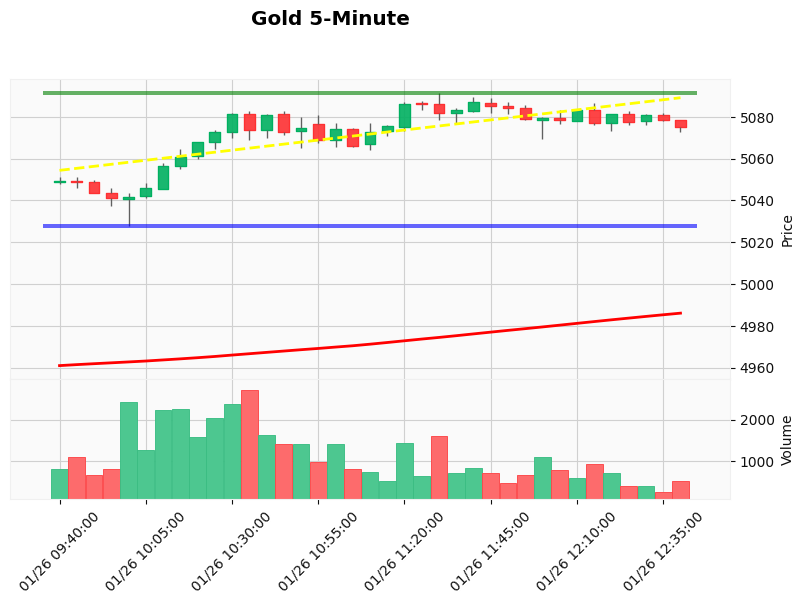

現在のレンジ：5091.5　～　5028.0
トレンドの傾き：上昇


In [12]:
# Gold (XAU/USD) データ取得
symbol = "GC=F"

df = yf.download(
    symbol,
    interval="5m",
    period="5d",
    progress=False
)

## 1. データの整理 ##
# MultiIndexの解除
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# 数値への変換
for col in ["Open", "High", "Low", "Close", "Volume"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# 欠損値の削除とタイムゾーン（日本時間）とIndex名の変更
df.dropna(inplace=True)
if df.index.tz is None:
    df.index = df.index.tz_localize('UTC')
df.index = df.index.tz_convert('Asia/Tokyo')
df.index.name = "Datetime"

# テクニカル指標の計算
df['MA200'] = df['Close'].rolling(window=200).mean()

# 時間範囲の指定
end_time = df.index[-1]
start_time = end_time - timedelta(hours=3) # 3時間
df_plot = df[df.index >= start_time].copy()

## 2. 予測 ##

# A. レンジの取得
period_high = df_plot['High'].max()
period_low = df_plot['Low'].min()

# B. トレンド予測
x = np.arange(len(df_plot))
y = df_plot['Close'].values
# 1次関数（y = ax + b）
slope, intercept = np.polyfit(x, y, 1)
# トレンドラインを作成
df_plot['Trend'] = slope * x + intercept

## 3. プロット設定 ##
if df_plot.empty:
    print("データがありません")

else:
    ap = [
        # 200MA（赤）
        mpf.make_addplot(df_plot['MA200'], color='red', width=2),
        # トレンド予測線（黄色）
        mpf.make_addplot(df_plot['Trend'], color='yellow', width=2, linestyle='--')
        ]
    
    lines = dict(hlines=[period_high, period_low], colors=['green', 'blue'], linewidths=1.5, alpha=0.6)

    mpf.plot (
        df_plot,
        type="candle",
        volume=True,
        style="yahoo",
        title="Gold 5-Minute",
        addplot=ap,
        hlines=lines,
        datetime_format="%m/%d %H:%M:%S",
        figsize=(10, 6)
    )

    print(f"現在のレンジ：{period_high}　～　{period_low}")
    print(f"トレンドの傾き：{'上昇' if slope > 0 else '下降'}")